<a href="https://colab.research.google.com/github/KhondamirRustamov/bioinformatics301/blob/main/examples/AlphaFold_single.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#AlphaFold - single sequence input
- WARNING - For DEMO and educational purposes only.
- For natural proteins you often need more than a single sequence to accurately predict the structure. See [ColabFold](https://colab.research.google.com/github/sokrypton/ColabFold/blob/main/AlphaFold2.ipynb) notebook if you want to predict the protein structure from a multiple-sequence-alignment. That being said, this notebook could be useful for evaluating *de novo* designed proteins and learning the idealized principles of proteins.

### Tips and Instructions
- Patience... The first time you run the cell below it will take 1 minitue to setup, after that it should run in seconds (after each change).
- click the little ▶ play icon to the left of each cell below.
- For 3D display, hold mouseover aminoacid to get name and position number
- use "/" to specify chainbreaks, (eg. sequence="AAA/AAA")


  0%|          | 0/1 [elapsed: 00:00 remaining: ?]

plotting prediction at recycle=0


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

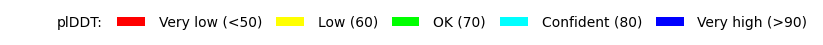

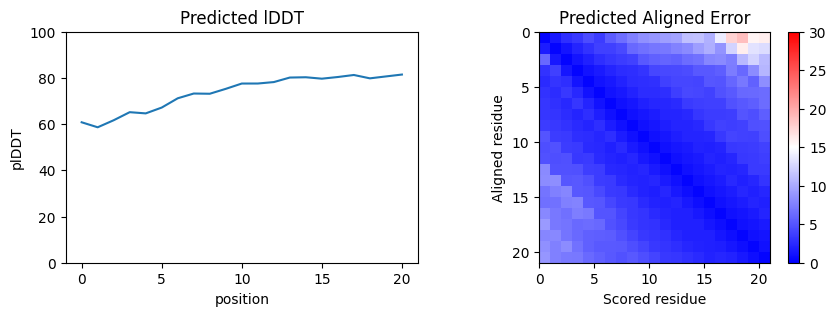

73.7144947052002


In [5]:
#@title Enter the amino acid sequence to fold ⬇️

###############################################################################
###############################################################################
#@title Setup
# import libraries
import os,sys,re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

if "SETUP_DONE" not in dir():
  from IPython.utils import io
  from IPython.display import HTML
  import tensorflow as tf
  import jax
  import jax.numpy as jnp
  import numpy as np
  import matplotlib
  from matplotlib import animation
  import matplotlib.pyplot as plt
  import tqdm.notebook
  TQDM_BAR_FORMAT = '{l_bar}{bar}| {n_fmt}/{total_fmt} [elapsed: {elapsed} remaining: {remaining}]'

  with io.capture_output() as captured:
    if not os.path.isdir("af_backprop"):
      %shell git clone https://github.com/sokrypton/af_backprop.git
      %shell pip -q install biopython dm-haiku ml-collections py3Dmol
      %shell wget -qnc https://raw.githubusercontent.com/sokrypton/ColabFold/main/beta/colabfold.py
    if not os.path.isdir("params"):
      %shell mkdir params
      %shell curl -fsSL https://storage.googleapis.com/alphafold/alphafold_params_2021-07-14.tar | tar x -C params

  # configure which device to use
  try:
    # check if TPU is available
    import jax.tools.colab_tpu
    jax.tools.colab_tpu.setup_tpu()
    print('Running on TPU')
    DEVICE = "tpu"
  except:
    if jax.local_devices()[0].platform == 'cpu':
      print("WARNING: no GPU detected, will be using CPU")
      DEVICE = "cpu"
    else:
      print('Running on GPU')
      DEVICE = "gpu"
      # disable GPU on tensorflow
      tf.config.set_visible_devices([], 'GPU')

  # import libraries
  sys.path.append('af_backprop')

  SETUP_DONE = True

if "LIBRARY_IMPORTED" not in dir():
  from utils import update_seq, update_aatype, get_plddt, get_pae
  import colabfold as cf
  from alphafold.common import protein
  from alphafold.data import pipeline
  from alphafold.model import data, config, model
  from alphafold.common import residue_constants

  # custom functions
  def clear_mem():
    backend = jax.lib.xla_bridge.get_backend()
    for buf in backend.live_buffers(): buf.delete()

  def setup_model(max_len, model_name="model_3_ptm"):
    clear_mem()

    # setup model
    cfg = config.model_config("model_5_ptm")
    cfg.model.num_recycle = 0
    cfg.data.common.num_recycle = 0
    cfg.data.eval.max_msa_clusters = 1
    cfg.data.common.max_extra_msa = 1
    cfg.data.eval.masked_msa_replace_fraction = 0
    cfg.model.global_config.subbatch_size = None
    model_params = data.get_model_haiku_params(model_name=model_name, data_dir=".")
    model_runner = model.RunModel(cfg, model_params, is_training=False)

    seq = "A" * max_len
    length = len(seq)
    feature_dict = {
        **pipeline.make_sequence_features(sequence=seq, description="none", num_res=length),
        **pipeline.make_msa_features(msas=[[seq]], deletion_matrices=[[[0]*length]])
    }
    inputs = model_runner.process_features(feature_dict,random_seed=0)

    def runner(I):
      # update sequence
      inputs = I["inputs"]
      inputs["prev"] = I["prev"]

      seq = jax.nn.one_hot(I["seq"],20)
      update_seq(seq, inputs)
      update_aatype(inputs["target_feat"][...,1:], inputs)

      # mask prediction
      mask = jnp.arange(inputs["residue_index"].shape[0]) < I["length"]
      inputs["seq_mask"] = inputs["seq_mask"].at[:].set(mask)
      inputs["msa_mask"] = inputs["msa_mask"].at[:].set(mask)
      inputs["residue_index"] = jnp.where(mask, inputs["residue_index"], 0)

      # get prediction
      key = jax.random.PRNGKey(0)
      outputs = model_runner.apply(I["params"], key, inputs)

      aux = {"final_atom_positions":outputs["structure_module"]["final_atom_positions"],
            "final_atom_mask":outputs["structure_module"]["final_atom_mask"],
            "plddt":get_plddt(outputs),"pae":get_pae(outputs),
            "length":I["length"], "seq":I["seq"],
            "prev":outputs["prev"],
            "residue_idx":inputs["residue_index"][0]}
      return aux

    return jax.jit(runner), {"inputs":inputs, "params":model_params, "length":max_length}

  def save_pdb(outs, filename):
    '''save pdb coordinates'''
    p = {"residue_index":outs["residue_idx"] + 1,
        "aatype":outs["seq"],
        "atom_positions":outs["final_atom_positions"],
        "atom_mask":outs["final_atom_mask"],
        "plddt":outs["plddt"]}
    p = jax.tree_map(lambda x:x[:outs["length"]], p)
    b_factors = 100 * p.pop("plddt")[:,None] * p["atom_mask"]
    p = protein.Protein(**p,b_factors=b_factors)
    pdb_lines = protein.to_pdb(p)
    with open(filename, 'w') as f: f.write(pdb_lines)

  def make_animation(positions, plddts, Ls=None, line_w=2.0, dpi=100):

    def ca_align_to_last(positions):
      def align(P, Q):
        p = P - P.mean(0,keepdims=True)
        q = Q - Q.mean(0,keepdims=True)
        return p @ cf.kabsch(p,q)

      pos = positions[-1,:,1,:] - positions[-1,:,1,:].mean(0,keepdims=True)
      best_2D_view = pos @ cf.kabsch(pos,pos,return_v=True)

      new_positions = []
      for i in range(len(positions)):
        new_positions.append(align(positions[i,:,1,:],best_2D_view))
      return np.asarray(new_positions)

    # align all to last recycle
    pos = ca_align_to_last(positions)

    fig, (ax1, ax2, ax3) = plt.subplots(1,3)
    fig.subplots_adjust(top = 0.90, bottom = 0.10, right = 1, left = 0, hspace = 0, wspace = 0)
    fig.set_figwidth(13)
    fig.set_figheight(5)
    fig.set_dpi(dpi)

    xy_min = pos[...,:2].min() - 1
    xy_max = pos[...,:2].max() + 1

    for ax in [ax1,ax3]:
      ax.set_xlim(xy_min, xy_max)
      ax.set_ylim(xy_min, xy_max)
      ax.axis(False)

    ax2.set_xlabel("positions")
    ax2.set_ylabel("pLDDT")
    ax2.set_ylim(0,100)

    ims=[]
    for k,(xyz,plddt) in enumerate(zip(pos,plddts)):
      ims.append([])
      im2 = ax2.plot(plddt, animated=True, color="black")[0]
      tt2 = cf.add_text(f"recycle={k}", ax2)
      tt3 = cf.add_text(f"pLDDT={plddt.mean():.3f}", ax3)
      if Ls is None or len(Ls) == 1:
        tt1 = cf.add_text("colored by N->C", ax1)
        ims[-1] += [cf.plot_pseudo_3D(xyz, ax=ax1, line_w=line_w)]
      else:
        # color by chain
        tt1 = cf.add_text("colored by chain", ax1)
        c = np.concatenate([[n]*L for n,L in enumerate(Ls)])
        ims[-1] += [cf.plot_pseudo_3D(xyz, c=c, cmap=cf.pymol_cmap, cmin=0, cmax=39, line_w=line_w, ax=ax1)]

      ims[-1] += [im2,tt1,tt2,tt3]
      ims[-1] += [cf.plot_pseudo_3D(xyz, c=plddt, cmin=50, cmax=90, ax=ax3, line_w=line_w)]

    ani = animation.ArtistAnimation(fig, ims, blit=True, interval=120)
    plt.close()
    return ani.to_html5_video()

  LIBRARY_IMPORTED = True

###############################################################################
###############################################################################

# initialize
if "current_seq" not in dir():
  current_seq = ""
  r = -1
  max_length = -1

# collect user inputs
sequence = 'AAAAAAAAAAAAAAAAAAAAA' #@param {type:"string"}
recycles = 0 #@param ["0", "1", "2", "3", "6", "12", "24", "48"] {type:"raw"}
ori_sequence = re.sub("[^A-Z\/\:]", "", sequence.upper())
Ls = [len(s) for s in ori_sequence.replace(":","/").split("/")]
sequence = re.sub("[^A-Z]","",ori_sequence)
length = len(sequence)

# avoid recompiling if length within 25
if length > max_length or (max_length - length) > 25:
  max_length = length + 25
  runner, I = setup_model(max_length)

if ori_sequence != current_seq:
  outs = []
  positions = []
  plddts = []
  paes = []
  r = -1

  # pad sequence to max length
  seq = np.array([residue_constants.restype_order.get(aa,0) for aa in sequence])
  seq = np.pad(seq,[0,max_length-length],constant_values=-1)

  # update inputs, restart recycle
  I.update({"seq":seq, "length":length,
            "prev":{'prev_msa_first_row': np.zeros([max_length, 256]),
                    'prev_pair': np.zeros([max_length, max_length, 128]),
                    'prev_pos': np.zeros([max_length, 37, 3])}})

  I["inputs"]['residue_index'][:] = cf.chain_break(np.arange(max_length), Ls, length=32)
  current_seq = ori_sequence

# run for defined number of recycles
with tqdm.notebook.tqdm(total=(recycles+1), bar_format=TQDM_BAR_FORMAT) as pbar:
  p = 0
  while p < min(r+1,recycles+1):
    pbar.update(1)
    p += 1
  while r < recycles:
    O = runner(I)
    O = jax.tree_map(lambda x:np.asarray(x), O)
    positions.append(O["final_atom_positions"][:length])
    plddts.append(O["plddt"][:length])
    paes.append(O["pae"][:length,:length])
    I["prev"] = O["prev"]
    outs.append(O)
    r += 1
    pbar.update(1)

#@markdown #### Display options
color = "confidence" #@param ["chain", "confidence", "rainbow"]
if color == "confidence": color = "lDDT"
show_sidechains = True #@param {type:"boolean"}
show_mainchains = False #@param {type:"boolean"}

print(f"plotting prediction at recycle={recycles}")
save_pdb(outs[recycles], "out.pdb")
v = cf.show_pdb("out.pdb", show_sidechains, show_mainchains, color,
                color_HP=True, size=(800,480), Ls=Ls)
v.setHoverable({}, True,
               '''function(atom,viewer,event,container){if(!atom.label){atom.label=viewer.addLabel("      "+atom.resn+":"+atom.resi,{position:atom,backgroundColor:'mintcream',fontColor:'black'});}}''',
               '''function(atom,viewer){if(atom.label){viewer.removeLabel(atom.label);delete atom.label;}}''')
v.show()
if color == "lDDT":
  cf.plot_plddt_legend().show()

# add confidence plots
cf.plot_confidence(plddts[recycles]*100, paes[recycles], Ls=Ls).show()
print(np.mean(plddts)*100)

In [4]:
print(np.mean(plddts)*100)

62.65328526496887


In [ ]:
#@title Animate
#@markdown - Animate trajectory if more than 0 recycle(s)
HTML(make_animation(np.asarray(positions),
                    np.asarray(plddts) * 100.0, Ls=Ls))